# Upset prediction

Notebook used for:
- Processing tournament data
- Predicting upsets with game data using a logistic regression classifier model

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

# Import and process data

In [3]:
# Input data directory
datadir = os.path.join('data', 'kaggle')

## Import

In [4]:
mtourney_results = pd.read_csv(os.path.join(datadir, 'MNCAATourneyCompactResults.csv'))
mteams = pd.read_csv(os.path.join(datadir, 'MTeams.csv'), index_col='TeamID')
mtourney_seeds = pd.read_csv(os.path.join(datadir, 'MNCAATourneySeeds.csv'))
MNCAATourneyDetailedResults = pd.read_csv(os.path.join('data', 'kaggle', 'MNCAATourneyDetailedResults.csv'))

## Tournament round/seed data

In [5]:
## Process mtourney_results dataframe

# Exclude 2021 due to odd tournament schedule
mtourney_results = mtourney_results.loc[mtourney_results['Season'] != 2021]

# Create columns for each team with the season and the team ID
mtourney_results['WSeasonTeamID'] = mtourney_results['Season'].astype(str) + '_' + mtourney_results['WTeamID'].astype(str)
mtourney_results['LSeasonTeamID'] = mtourney_results['Season'].astype(str) + '_' + mtourney_results['LTeamID'].astype(str)

# Retrieve team names using team IDs
mtourney_results['WTeamName'] = mteams.loc[mtourney_results['WTeamID'], 'TeamName'].values
mtourney_results['LTeamName'] = mteams.loc[mtourney_results['LTeamID'], 'TeamName'].values

# Set index of mtourney_seeds to be "Season_TeamID" - same as WSeasonTeamID and LSeasonTeamID columns
mtourney_seeds.index = mtourney_seeds['Season'].astype(str) + '_' + mtourney_seeds['TeamID'].astype(str)

# Raw seed columns
mtourney_results['WSeedRaw'] = mtourney_seeds.loc[mtourney_results['WSeasonTeamID'], 'Seed'].values
mtourney_results['LSeedRaw'] = mtourney_seeds.loc[mtourney_results['LSeasonTeamID'], 'Seed'].values

# Process into readable seeds
mtourney_results['WSeed'] = mtourney_results['WSeedRaw'].str.lstrip('WXYZ').str.rstrip('ab').astype(int)
mtourney_results['LSeed'] = mtourney_results['LSeedRaw'].str.lstrip('WXYZ').str.rstrip('ab').astype(int)

# Translates days into rounds
day_to_round = {
    136:1, 137:1,
    138:2, 139:2,
    143:3, 144:3,
    145:4, 146:4,
    152:5,
    154:6,
}
def getRound(day):
    if day in day_to_round:
        return day_to_round[day]
    return float('NaN')

# Create round column
mtourney_results['Round'] = mtourney_results['DayNum'].apply(getRound)
mtourney_results = mtourney_results.loc[~mtourney_results['Round'].isna()]

# Output processed dataframe for another project
mtourney_results.to_csv('data/mtourney_results_processed.csv', index=False)

## Detailed game data

In [6]:
game_stats = ['Ast',
 'Blk',
 'DR',
 'FGA',
 'FGA3',
 'FGM',
 'FGM3',
 'FTA',
 'FTM',
 'OR',
 'PF',
 'Stl',
 'TO']

for stat in game_stats:
    MNCAATourneyDetailedResults[f'Total_{stat}'] = MNCAATourneyDetailedResults[f'W{stat}'] + MNCAATourneyDetailedResults[f'L{stat}']    

In [7]:
# Make the index "Season_DayNum_WTeamID_LTeamID"
def getGameID(df):
    return df['Season'].astype(str) + '_' + df['DayNum'].astype(str) + '_' + df['WTeamID'].astype(str) + '_' + df['LTeamID'].astype(str)
mtourney_results.index = getGameID(mtourney_results)
MNCAATourneyDetailedResults.index = getGameID(MNCAATourneyDetailedResults)

# Sanity checks
assert not mtourney_results.index.duplicated().any()
assert not MNCAATourneyDetailedResults.index.duplicated().any()

## Upset columns

In [8]:
mtourney_results['Upset'] = mtourney_results['WSeed'] - 5 >= mtourney_results['LSeed']
mtourney_results['MissedUpset'] = mtourney_results['LSeed'] - 5 >= mtourney_results['WSeed']
assert not np.any(mtourney_results['MissedUpset'] & mtourney_results['Upset']) # Sanity check

# Transfer data to other dataframe
MNCAATourneyDetailedResults['Upset'] = mtourney_results['Upset']
MNCAATourneyDetailedResults['MissedUpset'] = mtourney_results['MissedUpset']

# Upset prediction

## Train classifier

In [9]:
# Helper function to return a shuffled copy of an array
def shuffle(x):
    xc = x.copy()
    np.random.shuffle(xc)
    return xc

In [10]:
predictors = [f'W{stat}' for stat in game_stats] + [f'L{stat}' for stat in game_stats]
n_features = len(predictors)
y_var = 'Upset'

# Grab all training/test data
# Restrict to possible upsets
all_data = MNCAATourneyDetailedResults.loc[MNCAATourneyDetailedResults['Upset'] | MNCAATourneyDetailedResults['MissedUpset'], predictors + [y_var]].dropna()

# X data
all_X = all_data[predictors]
all_X = (all_X - all_X.mean(axis=0)) / all_X.std(axis=0) # Normalize

# Y data
all_y = all_data[y_var].astype(int)

# upset_idxs = np.where(all_y)[0]
# not_upset_idxs = np.where(~all_y)[0]

# Record things for each model trained
accuracy_list = []
logreg_model_coef_sum = np.zeros(n_features)     # Sum of the coefficients for each model trained - used to calculate average

# Do 20 iterations and average the results
n_testing_iter = 20
for i in range(n_testing_iter):
    ######################################################################
    ################## Set up training and testing sets ##################
    ######################################################################
    
    test_size = 0.2

    # Indices of upsets and missed upsets
    upset_idxs = np.where(all_y == True)[0]
    not_upset_idxs = np.where(all_y == False)[0]

    # Shuffle indicies
    upset_idxs_shuffled = shuffle(upset_idxs)
    not_upset_idxs_shuffled = shuffle(not_upset_idxs)

    # The dataset is imbalanced -- far more missed upsets than upsets
    # So we will use all the upset games
    # And only use the same number of missed upset games
    
    # Pick indices of test and train upset games
    # Record number of games in each of these sets
    n_test_upset = int(test_size * upset_idxs.shape[0])
    test_upset_idxs = upset_idxs_shuffled[:n_test_upset]
    train_upset_idxs = upset_idxs_shuffled[n_test_upset:]
    n_train_upset = train_upset_idxs.shape[0]

    # Pick missed upsets
    test_not_upset_idxs = not_upset_idxs_shuffled[:n_test_upset]
    train_not_upset_idxs = not_upset_idxs_shuffled[n_test_upset:(n_train_upset+n_test_upset)]

    # Combine upset and missed upset indices
    train_idxs = shuffle(np.concatenate([train_upset_idxs, train_not_upset_idxs]))
    test_idxs = shuffle(np.concatenate([test_upset_idxs, test_not_upset_idxs]))

    # Produce training and test X and y dataframes
    train_X = all_X.iloc[train_idxs]
    train_y = all_y.iloc[train_idxs]

    test_X = all_X.iloc[test_idxs]
    test_y = all_y.iloc[test_idxs]
    ######################################################################
    ######################################################################
    ######################################################################

    # Train model with L1 penalty
    logreg_model = LogisticRegressionCV(max_iter=1000, cv=10, penalty='l1', solver='saga')
    logreg_model.fit(train_X, train_y)
    
    # Record accuracy
    accuracy = logreg_model.score(test_X, test_y)
    accuracy_list.append(accuracy)
    
    # Add coefficients to running sum to be averaged later
    logreg_model_coef_sum += logreg_model.coef_[0]
    
# Print average accuracy
print(np.mean(accuracy_list))

0.684375


## Plot coefficients

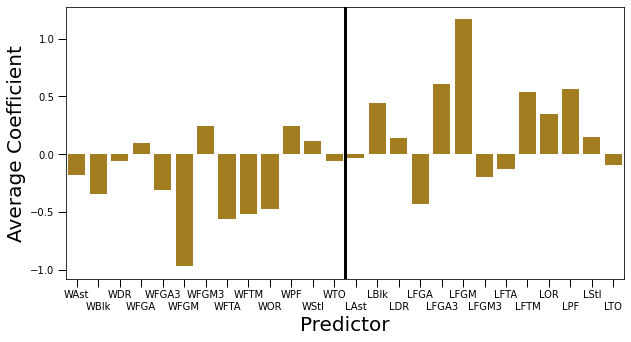

In [25]:
# Display mean coefficient of each predictor over all iterations
# Winning and Losing stats are predctors


fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=predictors, y=logreg_model_coef_sum / n_testing_iter, color='darkgoldenrod')

ax.set_ylabel('Average Coefficient', fontsize=20)
ax.set_xlabel('Predictor', fontsize=20)
# ax.set_title('Logistic Regression for Predicting Upsets', fontsize=30)

ax.set_xticklabels(["\n"*(i%2) + l for i,l in enumerate(predictors)])

ax.tick_params(axis='both', labelsize=10, width=1, length=8)


ax.axvline(x=12.5, color='black', lw=3)

## Evaluate model with ROC AUC

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_19087/1642257967.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


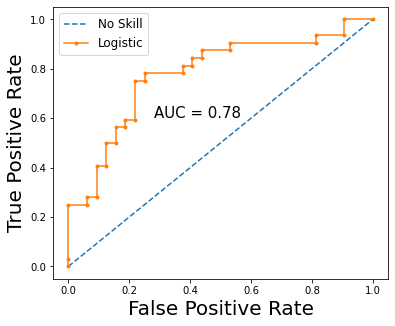

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

fig, ax = plt.subplots(figsize=(6, 5))

# predict probabilities
yhat = logreg_model.predict_proba(test_X)

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]

# plot no skill roc curve
ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for model
fpr, tpr, _ = roc_curve(test_y, pos_probs)

# calculate roc auc
auc = roc_auc_score(test_y, pos_probs)

# plot model roc curve
ax.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
# show the legend
ax.legend(fontsize="large")

ax.text(0.28, 0.6, f'AUC = {auc:.2f}', fontsize=15)

# show the plot
fig.show()